In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/koi-dataset/koi_dataset.csv


In [2]:
from sklearn.model_selection import train_test_split

# precision - 0.8001474639668104, recall - 0.75168507493177.
data_set = pd.read_csv('/kaggle/input/koi-dataset/koi_dataset.csv', comment='#');
# 0.8243907351815674 0.7923935148763316
# data_set = pd.read_csv('/kaggle/input/kepler-dataset-nasa-space-apps/cumulative_2025.09.17_01.26.53.csv', comment='#');


train_set, test_set = train_test_split(data_set, test_size=0.2, random_state=43)
y_train = train_set['koi_disposition'].copy()
X_train = train_set.drop('koi_disposition', axis=1)
y_test = test_set['koi_disposition'].copy()
X_test = test_set.drop('koi_disposition', axis=1)

In [3]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin

class AdvancedFeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        df = X.copy()
        df['stellar_density'] = 10**df['koi_slogg']
        df['prad_srad_ratio'] = df['koi_prad'] / df['koi_srad']
        G = 6.67430e-11
        period_sec = df['koi_period'] * 86400
        mass_star = (10**df['koi_slogg'] * (df['koi_srad'] * 6.957e+8)**2) / G
        radius_star_m = df['koi_srad'] * 6.957e+8
        df['a_div_Rs'] = ((G * mass_star * period_sec**2) / (4 * np.pi**2))**(1/3) / radius_star_m
        return df.drop(columns=['koi_slogg', 'koi_srad', 'koi_period'], errors='ignore')

# --- ИСПРАВЛЕННЫЙ ПАЙПЛАЙН ---

# 1. Отбираем только числовые колонки. На этом шаге все строковые ('object') колонки отсеиваются.
X_train_numeric = X_train.select_dtypes(include=np.number)
X_test_numeric = X_test.select_dtypes(include=np.number)

# 2. Удаляем числовые ID и бесполезные колонки
del_cols = ['kepid'] # 'koi_pdisposition' уже удален, т.к. он не числовой
X_train_temp = X_train_numeric.drop(columns=del_cols, errors='ignore')
X_test_temp = X_test_numeric.drop(columns=del_cols, errors='ignore')

# 3. Удаляем ЛЮБЫЕ колонки, которые полностью состоят из NaN (например, koi_teq_err1)
X_train_clean = X_train_temp.dropna(axis=1, how='all')
# Убеждаемся, что в тестовом наборе остались те же колонки, что и в тренировочном
cols_to_keep = X_train_clean.columns
X_test_clean = X_test_temp[cols_to_keep]

# 4. Теперь импьютер получает на вход только полезные числовые данные
imputer = IterativeImputer(max_iter=10, random_state=4)
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_clean), columns=X_train_clean.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test_clean), columns=X_test_clean.columns)

# 5. Применяем Feature Engineering
feature_engineer = AdvancedFeatureEngineer()
X_train_featured = feature_engineer.fit_transform(X_train_imputed)
X_test_featured = feature_engineer.transform(X_test_imputed)

# 6. Финальное масштабирование
scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train_featured)
X_test_transformed = scaler.transform(X_test_featured)

# 7. Кодируем 'y' (целевую переменную) ПРАВИЛЬНО
encoder = OrdinalEncoder()
y_train_transformed = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_transformed = encoder.transform(y_test.values.reshape(-1, 1)) # <-- Используем .transform()

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


0.9273295023720435
0.9262602916876762
0.9267307908386768


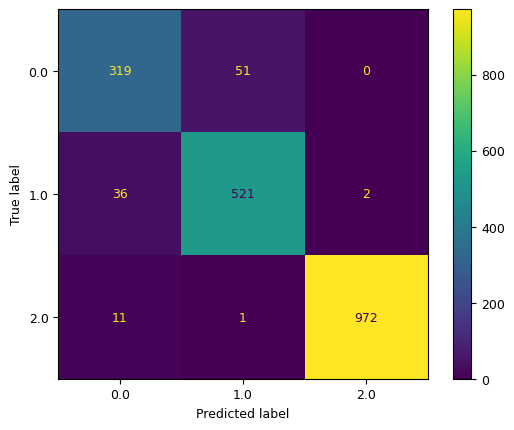

In [7]:
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_sample_weight
import xgboost as xgb


sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train_transformed.ravel()
)

best_params = {'alpha': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'lambda': 10, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 400, 'subsample': 0.8}

boost_test_model = xgb.XGBClassifier(
    random_state=42,
    tree_method='hist',
    device='cuda',  
    objective='multi:softmax',
    num_class=3,
    **best_params
)

boost_test_model.fit(X_train_transformed, y_train_transformed.ravel(), sample_weight=sample_weights)

y_pred = boost_test_model.predict(X_test_transformed)

boost_test_model.save_model("boost_test_model.json")

print(recall_score(y_test_transformed, y_pred, average='macro'))
print(precision_score(y_test_transformed, y_pred, average='macro'))
print(f1_score(y_test_transformed, y_pred, average='macro'))

plt.rc('font', size=9) 
ConfusionMatrixDisplay.from_predictions(y_test_transformed, y_pred)

In [5]:
from sklearn.metrics import classification_report

y_pred = boost_test_model.predict(X_test_transformed)
print(classification_report(y_test_transformed, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.86      0.87       370
         1.0       0.91      0.93      0.92       559
         2.0       1.00      0.99      0.99       984

    accuracy                           0.95      1913
   macro avg       0.93      0.93      0.93      1913
weighted avg       0.95      0.95      0.95      1913



In [6]:
# from sklearn.model_selection import RandomizedSearchCV
# import xgboost as xgb

# # Define the expanded parameter grid with more regularization
# param_grid = {
#     # Core parameters
#     'n_estimators': [100, 200, 300, 500],
#     'max_depth': [3, 4, 5, 6, 7],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],

#     # Regularization parameters
#     'gamma': [0, 0.1, 0.2, 0.3, 0.4],
#     'min_child_weight': [1, 3, 5, 7],
#     'lambda': [0, 0.1, 1, 2, 5],  # L2 regularization
#     'alpha': [0, 0.1, 1, 2, 5],   # L1 regularization

#     # Stochastic parameters for regularization
#     'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
# }

 

# # Initialize your XGBoost classifier
# boost_model = xgb.XGBClassifier(
#     random_state=42,
#     tree_method='hist',
#     device='cuda',
#     objective='multi:softmax',
#     num_class=3
# )

# # Set up RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=boost_model,
#     param_distributions=param_grid,
#     n_iter=75,  # Increased iterations for the larger grid
#     scoring='f1_macro',
#     n_jobs=-1,
#     cv=5,
#     verbose=2,
#     random_state=42
# )

# # Fit the random search to your data
# random_search.fit(X_train_transformed, y_train_transformed.ravel(), sample_weight=sample_weights)

# # Print the best parameters found
# print("Best parameters found: ", random_search.best_params_)
# print("Best F1-score found: ", random_search.best_score_)